A **Dueling Double Deep Q Network with Priority Experience Replay (Duel DDQN with PER)**
implementation in tensorflow. The code is tested with Gym's discrete action space environment,
CartPole-v0 on Colab.

---

## Notations:

Model network = $Q_{\theta}$

Model parameter = $\theta$

Model network Q value = $Q_{\theta}$ (s, a)

Target network = $Q_{\phi}$

Target parameter = $\phi$

Target network Q value = $Q_{\phi}$ ($s^{\prime}$, $a^{\prime}$)

A small constant to ensure that no sample has 0 probability to be selected = e

Hyper parameter  = $\alpha$

- Decides how to sample, range from 0 to 1, where 0 corresponds to fully
uniformly random sample selection & 1 corresponding to selecting samples based
on highest priority.  

Hyper parameter  = $\beta$

- Starts close to 0, gradually annealed  to 1, slowly giving more importance to weights during training.

Minibatch size = k

Replay memory size = N

---

## Equations:

TD target =
r (s, a)
$+$
$\gamma$
$Q_{\phi}$
($s^{\prime}$,
$argmax_{a^{\prime}}$
$Q_{\theta}$
(s$^{\prime}$, a$^{\prime}$))

TD error =
${\delta}$ = 
(TD target)
$-$
(Model network Q value) =
[r (s, a)
$+$
$\gamma$
$Q_{\phi}$
($s^{\prime}$,
$argmax_{a^{\prime}}$
$Q_{\theta}$
(s$^{\prime}$,
a$^{\prime}$))]
$-$
$Q_{\theta}$
(s, a)

$priority_{i}$ =
$p_{i}$ =
${|\delta_{i}|}$ $+$ e

probability(i) =
P(i) =
$\frac{p_{i}^{\alpha}}  
{\sum_{k}p_{k}^{\alpha}}$

weights =
$w_{i}$ = 
(N $\cdot$ P(i))
$^{-\beta}$

---

## Key implementation details:

**Sum tree:**

Assume an example of a sum tree with 7 nodes (with 4 leaves which corresponds to the replay memory size):

At initialization:
![Image](https://raw.githubusercontent.com/ChuaCheowHuan/reinforcement_learning/master/DQN_variants/duel_DDQN_PER/img/pic_1.png)

When item 1 is added:
![Image](https://raw.githubusercontent.com/ChuaCheowHuan/reinforcement_learning/master/DQN_variants/duel_DDQN_PER/img/pic_2.png)

When item 2 is added:
![image](https://raw.githubusercontent.com/ChuaCheowHuan/reinforcement_learning/master/DQN_variants/duel_DDQN_PER/img/pic_3.png)

When item 3 is added:
![image](https://raw.githubusercontent.com/ChuaCheowHuan/reinforcement_learning/master/DQN_variants/duel_DDQN_PER/img/pic_4.png)

When item 4 is added:
![image](https://raw.githubusercontent.com/ChuaCheowHuan/reinforcement_learning/master/DQN_variants/duel_DDQN_PER/img/pic_5.png)

When item 5 is added:
![image](https://raw.githubusercontent.com/ChuaCheowHuan/reinforcement_learning/master/DQN_variants/duel_DDQN_PER/img/pic_6.png)

Figure below shows the corresponding code & array contents. The tree represents the entire sum tree while data represents the leaves.

![image](https://raw.githubusercontent.com/ChuaCheowHuan/reinforcement_learning/master/DQN_variants/duel_DDQN_PER/img/pic_7.png)

In the implementation, only one sumTree object is needed to store the collected experiences, this sumTree object resides in the Replay_memory class. The sumTree object has number of leaves = replay memory size = capacity.
The data array in sumTree object stores an Exp object, which is a sample of experience.

The following code decides how to sample:

```
def sample(self, k): # k = minibatch size
    batch = []

    # total_p() gives the total sum of priorities of the leaves in the sumTree
    # which is the value stored in the root node
    segment = self.tree.total_p() / k

    for i in range(k):
        a = segment * i # start of segment
        b = segment * (i + 1) # end of segment
        s = np.random.uniform(a, b) # rand value between a, b

        (idx, p, data) = self.tree.get(s)
        batch.append( (idx, p, data) )            

    return batch    
```

Refer to appendix B.2.1, under the section, "Proportional prioritization", from the original (Schaul et al., 2016) [paper](https://arxiv.org/pdf/1511.05952.pdf) for sampling details.

---

## References:

[Prioritized experience replay (Schaul et al., 2016)](https://arxiv.org/pdf/1511.05952.pdf)


#Use tensorflow 1.15.2

In [1]:
!pip install tensorflow==1.15.2

     |████████████████████████████████| 110.5MB 48kB/s 
     |████████████████████████████████| 512kB 43.8MB/s 
     |████████████████████████████████| 3.8MB 44.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d9626a360b5674859d151925281203686d368ead11414840801bfe6bcd2cb379
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installatio

#Imports

In [0]:
import tensorflow as tf
import gym
import numpy as np
from matplotlib import pyplot as plt

#Experience (store each sample as data obj in leaves) for replay learning

In [0]:
# experience (store each sample as data obj in leaves) for replay learning
class Exp():
    def __init__(self, obs_size, max_size):
        self.obs_size = obs_size
        self.max_size = max_size
        
        self.mem = {'s'        : np.zeros(self.max_size * self.obs_size, dtype=np.float32).reshape(self.max_size,self.obs_size),
                    'a'        : np.zeros(self.max_size * 1, dtype=np.int32).reshape(self.max_size,1),
                    'r'        : np.zeros(self.max_size * 1).reshape(self.max_size,1),
                    's_next'   : np.zeros(self.max_size * 1 * self.obs_size, dtype=np.float32).reshape(self.max_size,1,self.obs_size),
                    'terminal' : np.zeros(self.max_size * 1, dtype=np.int32).reshape(self.max_size,1)}

    # stores obervation at each time step in memory as experience
    def store(self, s, a, r, s_next, done):
        i = 0
        
        self.mem['s'][i,:] = s
        self.mem['a'][i,:] = a
        self.mem['r'][i,:] = r
        self.mem['s_next'][i,:] = s_next
        self.mem['terminal'][i,:] = done

#Sumtree class

In [0]:
# Acknowledgments: This class is adapted & modified from the code found on 
# https://github.com/jaromiru/AI-blog/blob/master/SumTree.py
class SumTree:
    pointer = 0 # pointer to latest entry

    def __init__(self, capacity):
        self.capacity = capacity # minibatch size
        self.tree = np.zeros( 2*capacity - 1 ) # size = number of nodes in sumtree including leaves
        self.data = np.zeros( capacity, dtype=object ) # size = number of leaves of sumtree
  
    def total_p(self):
        return self.tree[0] # root node priority of sumtree

      
      
    def add(self, p, data): # takes in priority & data of transition
        i = self.pointer + self.capacity - 1

        self.data[self.pointer] = data
        self.update(i, p)
        
        self.pointer += 1
        # reset pointer
        if self.pointer >= self.capacity:
            self.pointer = 0

    def update(self, i, p):
        chg = p - self.tree[i]

        self.tree[i] = p # update priority of tree at i 
                
        self._propagate(i, chg)

    def _propagate(self, i, chg):
        parent = (i - 1) // 2 # uses floor division

        self.tree[parent] += chg # update priority of parent node

        if parent != 0: # ends recursion if parent = root node
            self._propagate(parent, chg)
            
            
            
    def get(self, s):
        i = self._retrieve(0, s) # i = node index in tree
        data_i = i - self.capacity + 1 # data index

        # return parent node index in tree, parent node priority in tree & data
        return (i, self.tree[i], self.data[data_i])
      
    def _retrieve(self, i, s): # i = parent node beginning at root, s = uniform random priority within a segment
        
        left = 2 * i + 1 # left child of i
        right = left + 1 # right child of i
        
        if left >= len(self.tree): # when traversing reached end of tree array
            return i

        if s <= self.tree[left]:
            return self._retrieve(left, s) # move down to left of tree with parent node = left
        else:
            return self._retrieve(right, s - self.tree[left]) # move down to right of tree with parent node = right

#Replay memory class

In [0]:
# Acknowledgments: This class is adapted & modified from the code found on 
# https://github.com/jaromiru/AI-blog/blob/master/Seaquest-DDQN-PER.py.py
class Replay_memory: # stored as ( s, a, r, s_, done ) in SumTree    
    def __init__(self, capacity, e, a, beta, beta_increment):
        self.tree = SumTree(capacity)
        self.e = e
        self.a = a
        self.beta = beta
        self.beta_increment = beta_increment

    def _getPriority(self, error):
        p = (error + self.e) ** self.a
        return p
      
    def add(self, sample):
        max_p = np.max(self.tree.tree[-self.tree.capacity:])
        if max_p == 0: # no priority updates to tree yet
            max_p = 1  
        self.tree.add(max_p, sample) 

    def sample(self, k): # k = minibatch size
        batch = []
        
        # total_p() gives the total sum of priorities of the leaves in the sumTree 
        # which is the value stored in the root node
        segment = self.tree.total_p() / k 
  
        for i in range(k):
            a = segment * i # start of segment
            b = segment * (i + 1) # end of segment
            s = np.random.uniform(a, b) # rand value between a, b

            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, p, data) )            
            
        return batch      
      
    # compute probabilities    
    def prob(self, priority):         
        return ( priority / np.sum(priority) )       
        #return ( priority / self.tree.total_p() )       
            
    # compute importance sampling weights          
    # where N = replay memory size, k = minibatch size
    def IS_w(self, i, N, k, Prob):
        self.beta = np.min([self.beta + self.beta_increment, 1.0]) # max(beta) = 1
        
        W = np.power(N * Prob, -self.beta)
        #W = np.power(k * Prob, -self.beta)
        W = W / np.max(W)
            
        return W 
      
    def update(self, i, abs_td_err): # update priority in sumtree only after sample is used in training
        abs_td_err = np.minimum(abs_td_err, 1) # clipped abs_td_err
        
        p = self._getPriority(abs_td_err)
        self.tree.update(i, p)
        
    def batch_update(self, i, abs_td_err):
        for _i, _abs_td_err in zip(i, abs_td_err):
            self.update(_i, _abs_td_err)        

#The agent

In [0]:
# Evaluates behavior policy while improving target policy
class duel_DDQN_PER_agent():
    def __init__(self, num_actions, obs_size, nhidden,
                 epoch, 
                 epsilon, gamma, learning_rate, 
                 replace, polyak, tau_step,
                 mem_size, minibatch_size, e, a, beta, beta_increment):
        super(duel_DDQN_PER_agent, self).__init__()
        
        self.actions = range(num_actions)
        self.num_actions = num_actions
        self.obs_size = obs_size # number of features
        self.nhidden = nhidden # hidden nodes
        
        self.epoch = epoch # for epsilon decay & to decide when to start training

        self.epsilon = epsilon # for eploration
        self.gamma = gamma # discount factor
        self.learning_rate = learning_rate # learning rate alpha
        
        # for params replacement
        self.replace = replace # type of replacement
        self.polyak = polyak # for soft replacement
        self.tau_step = tau_step # for hard replacement
        self.learn_step = 0 # steps after learning
        
        # for Experience replay
        self.mem_size = mem_size
        self.mem = Replay_memory(self.mem_size, e, a, beta, beta_increment) # memory that holds experiences
        self.minibatch_size = minibatch_size
        
        self.step = 0 # each step in a episode
                
        # for tensorflow ops
        self.built_graph()        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.target_replace_hard)
        
        self.cum_loss_per_episode = 0 # for charting display

        # decay epsilon after each epoch    
    def epsilon_decay(self):
        if self.step % self.epoch == 0:
            self.epsilon = max(.01, self.epsilon * .95)
            
    # epsilon-greedy behaviour policy for action selection   
    def act(self, s):
        if np.random.random() < self.epsilon:
            i = np.random.randint(0,len(self.actions))
        else: 
            # get Q(s,a) from model network
            Q_val = self.sess.run(self.model_Q_val, feed_dict={self.s: np.reshape(s, (1,s.shape[0]))})
            # get index of largest Q(s,a)
            i = np.argmax(Q_val)
            
        action = self.actions[i]   
        
        self.step += 1 
        self.epsilon_decay()
        
        return action     
    
    def learn(self, s, a, r, s_next, done):
        # stores observation in memory as experience at each time step 
        # self.mem.store(s, a, r, done)
        
        sample = Exp(self.obs_size, 1)
        sample.store(s, a, r, s_next, done)
        self.mem.add(sample)
        
        # starts training a minibatch from experience after 1st epoch
        if self.step > self.epoch:
            self.replay() # start training with experience replay

            
            
    def td_target(self, s_next, r, done, model_s_next_Q_val, target_Q_val):    
        # select action with largest Q value from model network
        model_max_a = tf.argmax(model_s_next_Q_val, axis=1, output_type=tf.dtypes.int32)
        
        arr = tf.range(tf.shape(model_max_a)[0], dtype=tf.int32) # create row indices        
        indices = tf.stack([arr, model_max_a], axis=1) # create 2D indices            
        max_target_Q_val = tf.gather_nd(target_Q_val, indices) # select minibatch actions from target network             
        max_target_Q_val = tf.reshape(max_target_Q_val, (self.minibatch_size,1))
        
        # if state = terminal, td_target = r
        td_target = (1.0 - tf.cast(done, tf.float32)) * tf.math.multiply(self.gamma, max_target_Q_val) + r
        # exclude td_target in gradient computation
        td_target = tf.stop_gradient(td_target)

        return td_target
      
    # select Q(s,a) from actions using e-greedy as behaviour policy from model network
    def predicted_Q_val(self, a, model_Q_val):        
        # create 1D tensor of length = number of rows in a
        arr = tf.range(tf.shape(a)[0], dtype=tf.int32)
        
        # stack by column to create indices for Q(s,a) selections based on a
        indices = tf.stack([arr, a], axis=1)
        
        # select Q(s,a) using indice from model_Q_val
        Q_val = tf.gather_nd(model_Q_val, indices)
        Q_val = tf.reshape(Q_val, (self.minibatch_size,1))
        
        return Q_val

      
      
    # contruct neural network
    def built_net(self, var_scope, w_init, b_init, features, num_hidden, num_output):              
        with tf.variable_scope(var_scope):          
          feature_layer = tf.contrib.layers.fully_connected(features, num_hidden, 
                                                            activation_fn = tf.nn.relu,
                                                            weights_initializer = w_init,
                                                            biases_initializer = b_init)
          V = tf.contrib.layers.fully_connected(feature_layer, 1, 
                                                activation_fn = None,
                                                weights_initializer = w_init,
                                                biases_initializer = b_init) 
          A = tf.contrib.layers.fully_connected(feature_layer, num_output, 
                                                activation_fn = None,
                                                weights_initializer = w_init,
                                                biases_initializer = b_init)   
          Q_val = V + (A - tf.reduce_mean(A, reduction_indices=1, keepdims=True)) # refer to eqn 9 from the original paper          
        return Q_val  
      
    # contruct tensorflow graph
    def built_graph(self):              
        tf.reset_default_graph()
        
        self.s = tf.placeholder(tf.float32, [None,self.obs_size], name='s')
        self.a = tf.placeholder(tf.int32, [None,], name='a')
        self.r = tf.placeholder(tf.float32, [None,1], name='r')
        self.s_next = tf.placeholder(tf.float32, [None,self.obs_size], name='s_next')
        self.done = tf.placeholder(tf.int32, [None,1], name='done') 
        self.model_s_next_Q_val = tf.placeholder(tf.float32, [None,self.num_actions], name='model_s_next_Q_val')
        self.IS_w = tf.placeholder(tf.float32, [None,1], name='IS_w')
        
        # weight, bias initialization
        w_init = tf.initializers.lecun_uniform()
        b_init = tf.initializers.he_uniform(1e-4)

        self.model_Q_val = self.built_net('model_net', w_init, b_init, self.s, self.nhidden, self.num_actions)
        self.target_Q_val = self.built_net('target_net', w_init, b_init, self.s_next, self.nhidden, self.num_actions)         

        with tf.variable_scope('td_target'):
          td_target = self.td_target(self.s_next, self.r, self.done, self.model_s_next_Q_val, self.target_Q_val)
        with tf.variable_scope('predicted_Q_val'):
          predicted_Q_val = self.predicted_Q_val(self.a, self.model_Q_val)
          
        with tf.variable_scope('abs_td_err'):
          #self.abs_td_err = tf.abs(td_target - predicted_Q_val)
          self.abs_td_err = tf.reduce_sum(tf.abs(td_target - predicted_Q_val), axis=1)
        with tf.variable_scope('loss'):
          self.loss = tf.losses.huber_loss(td_target, predicted_Q_val, weights = self.IS_w)
          #self.loss = tf.reduce_mean(tf.squared_difference(td_target, predicted_Q_val) * self.IS_w)

        with tf.variable_scope('optimizer'):
          self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)
          
        # get network params  
        with tf.variable_scope('params'):
          self.target_net_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='target_net')
          self.model_net_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model_net')  
        
        # replace target net params with model net params
        with tf.variable_scope('hard_replace'):
          self.target_replace_hard = [t.assign(m) for t, m in zip(self.target_net_params, self.model_net_params)]
        with tf.variable_scope('soft_replace'):            
          self.target_replace_soft = [t.assign(self.polyak * m + (1 - self.polyak) * t) for t, m in zip(self.target_net_params, self.model_net_params)]                
              
            
            
    # decide soft or hard params replacement        
    def replace_params(self):
        if self.replace == 'soft':
            # soft params replacement 
            self.sess.run(self.target_replace_soft)  
        else:
            # hard params replacement
            if self.learn_step % self.tau_step == 0:
                self.sess.run(self.target_replace_hard)  
            self.learn_step += 1

            
        
    def get_i(self, minibatch):  
        minibatch = np.array(minibatch)
        return minibatch[:,0]
      
    def get_IS_w(self, minibatch):            
        i = self.get_i(minibatch)
        
        minibatch = np.array(minibatch)
        priority = minibatch[:,1]                            
        
        Prob = self.mem.prob(priority)
        
        IS_w = self.mem.IS_w(i, self.mem_size, self.minibatch_size, Prob)      
        IS_w = np.asarray(IS_w, dtype=np.float32)
        IS_w = np.asarray(np.reshape(IS_w, (self.minibatch_size,1)))      
        
        return IS_w
      
    def get_samples(self, minibatch):  
        minibatch = np.array(minibatch)
        samples = minibatch[:,2]
        
        s = []
        a = []
        r = []
        s_next = []
        done = []
        for exp in samples:
          s.append( exp.mem['s'] )
          a.append( exp.mem['a'] )
          r.append( exp.mem['r'] )
          s_next.append( exp.mem['s_next'] )
          done.append( exp.mem['terminal'] )
        
        s = np.asarray(s, dtype=np.float32)
        s = np.asarray(np.reshape(s, (self.minibatch_size, self.obs_size)))
        
        a = np.asarray(a, dtype=np.int32)
        a = np.asarray(np.reshape(a, self.minibatch_size))
        
        r = np.asarray(r, dtype=np.float32)
        r = np.asarray(np.reshape(r, (self.minibatch_size,1)))
        
        s_next = np.asarray(s_next, dtype=np.float32)
        s_next = np.asarray(np.reshape(s_next, (self.minibatch_size, self.obs_size)))  
               
        done = np.asarray(done, dtype=np.int32)
        done = np.asarray(np.reshape(done, (self.minibatch_size,1)))   
        
        return (s, a, r, s_next, done)      
        
    
    
    def replay(self):             
        # select minibatch of experiences from memory for training
        minibatch = self.mem.sample(self.minibatch_size)        
        i = self.get_i(minibatch)
        IS_w = self.get_IS_w(minibatch)
        (s, a, r, s_next, done) = self.get_samples(minibatch)
        
        # select actions from model network
        model_s_next_Q_val = self.sess.run(self.model_Q_val, feed_dict={self.s: s_next})
        
        # training
        _, abs_td_err, loss = self.sess.run([self.optimizer, self.abs_td_err, self.loss], 
                                            feed_dict = {self.s: s,
                                                         self.a: a,
                                                         self.r: r,
                                                         self.s_next: s_next,
                                                         self.done: done,
                                                         self.model_s_next_Q_val: model_s_next_Q_val,
                                                         self.IS_w: IS_w})  
        self.cum_loss_per_episode += loss
        self.replace_params()        
        
        self.mem.batch_update(i, abs_td_err) # update tree priorities


#Helper functions

In [0]:
# compute stats
def stats(r_per_episode, R, cum_R, cum_R_episodes, 
          cum_loss_per_episode, cum_loss, cum_loss_episodes):
    r_per_episode = np.append(r_per_episode, R) # store reward per episode
    cum_R_episodes += R
    cum_R = np.append(cum_R, cum_R_episodes) # store cumulative reward of all episodes

    cum_loss_episodes += cum_loss_per_episode
    cum_loss = np.append(cum_loss, cum_loss_episodes) # store cumulative loss of all episodes
    
    return (r_per_episode, cum_R_episodes, cum_R, cum_loss_episodes, cum_loss)

# plot performance
def plot_charts(values, y_label):
  fig = plt.figure(figsize=(10,5))
  plt.title("DQN performance")
  plt.xlabel("Episode")
  plt.ylabel(y_label)
  plt.plot(values)
  plt.show(fig)
  
def display(r_per_episode, cum_R, cum_loss):
  plot_charts(r_per_episode, "Reward")
  plot_charts(cum_R, "cumulative_reward")
  plot_charts(cum_loss, "cumulative_loss")
  
  avg_r = np.sum(r_per_episode) / max_episodes
  print("avg_r", avg_r)  
  
  avg_loss = np.sum(cum_loss) / max_episodes
  print("avg_loss", avg_loss) 

#Rollout & train function

In [0]:
def run_episodes(env, agent, max_episodes):
  r_per_episode = np.array([0])
  cum_R = np.array([0])
  cum_loss = np.array([0])
  cum_R_episodes = 0
  cum_loss_episodes = 0
  
  # repeat each episode
  for episode_number in range(max_episodes):
    s = env.reset() # reset new episode
    done = False 
    R = 0 
            
    # repeat each step
    while not done:
      # select action using behaviour policy(epsilon-greedy) from model network
      a = agent.act(s)
      # take action in environment
      next_s, r, done, _ = env.step(a)
      # agent learns
      agent.learn(s, a, r, next_s, done)
      s = next_s
      
      R += r 

    (r_per_episode, cum_R_episodes, cum_R, cum_loss_episodes, cum_loss) = stats(r_per_episode, R, cum_R, cum_R_episodes, 
                                                                                agent.cum_loss_per_episode, cum_loss, cum_loss_episodes)
          
  display(r_per_episode, cum_R, cum_loss)

  env.close()

#Global variables (& hyperparameters)

In [0]:
env = gym.make('CartPole-v0') # openai gym environment

max_episodes = 500
epoch = 100

num_actions = env.action_space.n # number of possible actions
obs_size = env.observation_space.shape[0] # dimension of state space
nhidden = 128 # number of hidden nodes

epsilon = .9
gamma = .9
learning_rate = .3

replace = 'soft' # params replacement type, 'soft' for soft replacement or empty string '' for hard replacement
polyak = .001 
tau_step = 300 

mem_size = 30000
minibatch_size = 64

e = 0.01
a = 0.6 # a = 0, the uniform case
beta = 0.4 # IS_w fully compensate for the non-uniform probabilities P(i) if beta = 1
beta_increment = 0.001

%matplotlib inline

#Start training

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


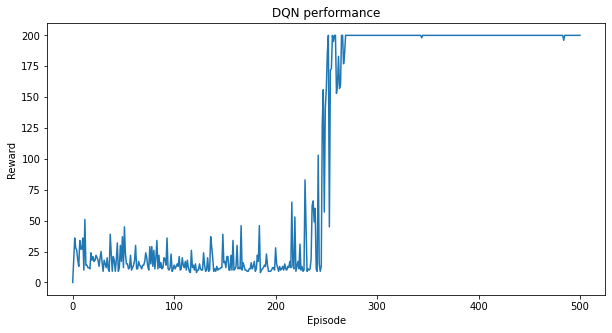

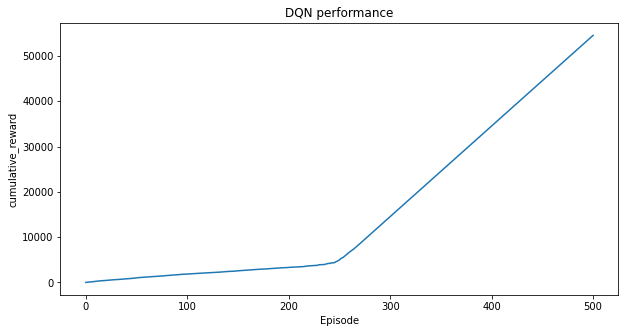

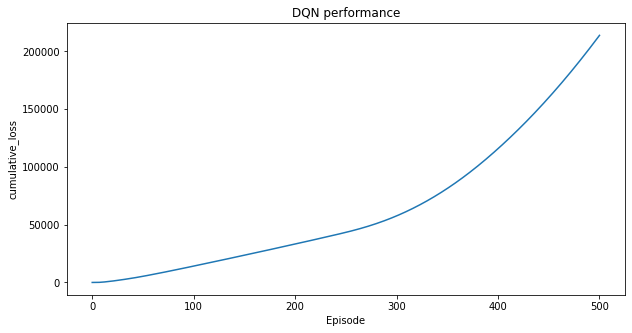

avg_r 109.07
avg_loss 63889.90933288527


In [10]:
agent = duel_DDQN_PER_agent(num_actions, obs_size, nhidden,
                            epoch, 
                            epsilon, gamma, learning_rate, 
                            replace, polyak, tau_step,
                            mem_size, minibatch_size, e, a, beta, beta_increment)
run_episodes(env, agent, max_episodes)